In [19]:
from abc import ABC

if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  %matplotlib inline
else:
    print('Not running on CoLab')
    %matplotlib notebook
    import os
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"

Running on CoLab


In [20]:
import time
from matplotlib.animation import FuncAnimation

from keras.models import Sequential
from keras.layers import Dense, GRU, Conv2D, Flatten, MaxPooling2D, Dropout, Reshape, TimeDistributed
from IPython.display import HTML
from funtion_file import *
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf
import keras as ks

In [37]:


class MatrixLister:
    def __init__(self, row_len, col_len, kernel_size, min_max_line_size, rotate, num_of_mat, num_per_mat):
        self.row_len = row_len
        self.col_len = col_len
        self.kernel_size = kernel_size
        self.min_max_line_size = min_max_line_size
        self.rotate = rotate
        self.num_of_mat = num_of_mat
        self.num_per_mat = num_per_mat

        self.con_matrix, self.line_pos_mat, self.con_alfa = self.create_matrix_in_list(32)



    def create_matrix_in_list(self, batch_size):
        list_matrix = []
        list_pos_mat = []
        list_alfa = []

        for k in range(0, int(batch_size/self.num_per_mat)):
            line_size = rotater((
                np.random.randint(self.min_max_line_size[0][0], self.min_max_line_size[1][0] + 1),
                np.random.randint(self.min_max_line_size[0][1], self.min_max_line_size[1][1] + 1)
            ))

            mat, pos, alf = matrix_maker(self.row_len, self.col_len, self.kernel_size, line_size, self.num_per_mat)

            list_matrix.append(mat)
            list_pos_mat.append(pos)
            list_alfa.append(alf)

        # Concatenate the lists along the first axis (axis=0)
        list_matrix = np.concatenate(list_matrix, axis=0)
        list_pos_mat = np.concatenate(list_pos_mat, axis=0)
        list_alfa = np.concatenate(list_alfa, axis=0)

        return list_matrix, list_pos_mat, list_alfa




    def plot_matrices(self, num_to_pred, new_mat=False, interval=500):
        if new_mat:
            self.num_of_mat = num_to_pred
            self.con_matrix, self.line_pos_mat, self.con_alfa = self.create_matrix_in_list(num_to_pred*self.num_per_mat)

        input_matrix = np.array(self.con_matrix[:num_to_pred*self.num_per_mat])
        true_matrix = self.line_pos_mat[:num_to_pred*self.num_per_mat]


        pred = predict_neural_network(input_matrix)

        predicted_line_pos_mat = np.array(pred).reshape(input_matrix.shape)

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 3 columns

        def update(frame):
            # Plot Input Matrix
            im = [axes[0].imshow(input_matrix[frame], interpolation='nearest', aspect='auto', vmin=0, vmax=1)]
            axes[0].set_title('Input Matrix')

            # Plot True Line Position Matrix
            im.append(axes[1].imshow(true_matrix[frame], interpolation='nearest', aspect='auto', vmin=0, vmax=1))
            axes[1].set_title('True Line Position Matrix')

            # Plot Predicted Line Position Matrix
            im.append(axes[2].imshow(predicted_line_pos_mat[frame], interpolation='nearest', aspect='auto', vmin=0, vmax=1))
            axes[2].set_title('Predicted Line Position Matrix')

            return im

        animation = FuncAnimation(fig, update, frames=len(input_matrix), interval=interval, repeat=False, blit=True)

        plt.tight_layout()
        return animation


class DataGenerator(ks.utils.Sequence, ABC):
    """Generates data for Keras"""
    def __init__(self, mat_obj):
        """Initialization"""
        self.mat_obj = mat_obj

    def __len__(self):
        'Denotes the number of batches per epoch'
        return 4

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate data
        x, y, _  = self.mat_obj.create_matrix_in_list(2*512)

        return np.expand_dims(x, -1), np.expand_dims(y, -1)


def predict_neural_network(model, in_data):
    input_data = np.expand_dims(np.array([matrix for matrix in in_data]),-1)
    return model.predict(input_data)


def rotater(line):
    if np.random.random() < 0.5:
        return line[::-1]
    return line


def plot(matrix, interval=200):
    fig, ax = plt.subplots()

    def update(frame):
        ax.clear()
        im = ax.imshow(matrix[frame], interpolation='nearest', aspect='auto', vmin=0, vmax=1)

        return [im]

    animation = FuncAnimation(fig, update, frames=len(matrix), interval=interval, repeat=False, blit=True)
    plt.tight_layout()
    plt.show(block=False)
    plt.show()
    return animation


def custom_loss(y_true, y_pred):
    # Define a mask to identify positions where y_true is 1
    mask = tf.cast(y_true, dtype=tf.bool)

    # Calculate mean squared error
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    # Penalize predictions less than 0.5 when y_true is 1
    penalty = tf.where(mask, tf.math.square(tf.maximum(0.5 - y_pred, 0)), 0)

    # Combine the mean squared error with the custom penalty
    combined_loss = mse_loss + 500*tf.reduce_mean(penalty)

    return combined_loss



In [28]:
row_len = 10
col_len = 12
kernel_size = (2, 2)
min_max_line_size = [(1,5),(1,8)]
rotate = True
num_of_mat = 250*2
numb_of_picture = 8
num_neuron = 256

matrix_lister = MatrixLister(row_len, col_len, kernel_size, min_max_line_size, rotate, num_of_mat, numb_of_picture)

In [29]:
model = Sequential()

# Apply Conv2D and Flatten to each time step
model.add(Conv2D(32, kernel_size=(1, 3), padding='same', activation='relu'))
model.add(Conv2D(32, kernel_size=(3, 1), padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(2, 2), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(128, kernel_size=(2, 2), padding='same', activation='tanh'))
#model.add(MaxPooling2D(pool_size=2))

# Apply SimpleRNN to the output of Conv2D and Flatten
model.add(TimeDistributed(Flatten()))
model.add(Dense(row_len*col_len, activation='tanh'))
model.add(GRU(num_neuron, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
model.add(GRU(num_neuron, activation='relu'))
model.add(Dense(num_neuron, activation='tanh'))

# Fully connected layer
model.add(Dense(row_len * col_len, activation='sigmoid'))

# Reshape to the desired output shape
model.add(Reshape((row_len, col_len, 1)))



In [38]:
model.compile(optimizer='adam',
loss=custom_loss,
metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

In [35]:
generator = DataGenerator(matrix_lister)

checkpoint_filepath = 'weights.h5'
model_checkpoint_callback = ks.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)



In [44]:
batch_size = 2**9
epochs = 250

start = time.time()
hist = model.fit_generator(generator=generator,validation_data=generator, epochs=epochs, callbacks=[model_checkpoint_callback])

print(time.time() - start)

<ipython-input-44-a815c358bf44>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(generator=generator,validation_data=generator, epochs=epochs, callbacks=[model_checkpoint_callback])


Epoch 1/250
4/4 [==============================] - 2s 628ms/step - loss: 0.1162 - accuracy: 0.9439 - precision: 0.4459 - recall: 0.7644 - val_loss: 0.1143 - val_accuracy: 0.9420 - val_precision: 0.4339 - val_recall: 0.7683
Epoch 2/250
4/4 [==============================] - 2s 496ms/step - loss: 0.1119 - accuracy: 0.9423 - precision: 0.4380 - recall: 0.7728 - val_loss: 0.1193 - val_accuracy: 0.9379 - val_precision: 0.4140 - val_recall: 0.7676
Epoch 3/250
4/4 [==============================] - 2s 490ms/step - loss: 0.1182 - accuracy: 0.9416 - precision: 0.4343 - recall: 0.7634 - val_loss: 0.1151 - val_accuracy: 0.9430 - val_precision: 0.4422 - val_recall: 0.7796
Epoch 4/250
4/4 [==============================] - 2s 483ms/step - loss: 0.1182 - accuracy: 0.9419 - precision: 0.4307 - recall: 0.7662 - val_loss: 0.1155 - val_accuracy: 0.9425 - val_precision: 0.4415 - val_recall: 0.7685
Epoch 5/250
4/4 [==============================] - 2s 473ms/step - loss: 0.1138 - accuracy: 0.9461 - precisi

In [42]:
ani = matrix_lister.plot_matrices(20)
plt.show()

TypeError: predict_neural_network() missing 1 required positional argument: 'in_data'

In [ ]:
if 'google.colab' in str(get_ipython()):
    HTML(ani.to_html5_video())

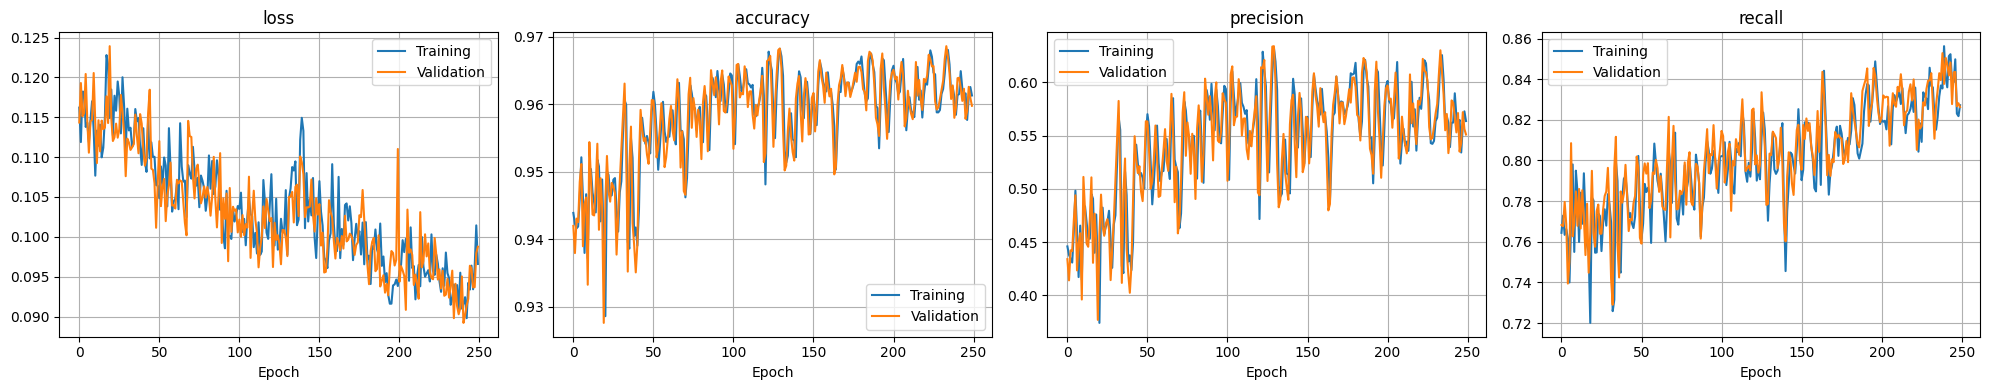

In [45]:
%matplotlib inline
plot_training_history(hist)